In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data.dataset as dataset
import numpy as np

from dataset import TestDataset
from model import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Load trained model
net = initialize_model2()
n_features = 512
tgt = 0

# Replace predictor
net.classifier = nn.Sequential(
        nn.Linear(n_features, 100),
        nn.Sigmoid(),
        nn.Linear(100, 20),
        nn.Sigmoid(),
        nn.Linear(20, 7)
    )

SAVED_MODEL_PATH = 'checkpoints/vgg11bn_4_e2e_all'
net.load_state_dict(torch.load(SAVED_MODEL_PATH))
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [4]:
def compute_integrated_gradient(X, y, model, steps=50):
    """
    Compute a class saliency map using the model for images X and labels y.
    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Targets for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    y = y.to(device)
    saliency = None
    criterion = nn.BCEWithLogitsLoss()
    means = torch.Tensor([10.1707, 14.8429, 25.7929, 
                          30.0618, 73.5301, 69.8245, 
                          48.3126, 69.7498, 62.0024])
    stds = torch.Tensor([6.0652,  7.4589, 10.7411, 
                         18.1305, 17.0735, 29.9055, 
                         28.0655,  8.7038, 8.7830])
    
    baseline = (torch.zeros_like(X)-means[None,:,None,None])/stds[None,:,None,None]
#     baseline = torch.randn_like(X)
    saliency = torch.zeros_like(X)
    for i in range(steps):
        in_tensor = baseline + (i+1)*X/steps
        in_tensor = in_tensor.to(device)
        in_tensor.requires_grad_()
        scores = model(in_tensor)
#         loss = criterion(scores, y)
        loss = scores.sum()
        loss.backward()
        saliency += in_tensor.grad.data.cpu()
#         if i == 0:
#             print(scores)
        
    saliency = X * saliency / steps
    saliency = torch.abs(saliency).sum(1)
    
    with torch.no_grad():
        scores = model(X.to(device))
    return saliency, y, torch.sigmoid(scores)

In [5]:
def prepare(X_raw):
    #Un-normalize X and prepare it for plotting
    means = torch.Tensor([10.1707, 14.8429, 25.7929, 
                          30.0618, 73.5301, 69.8245, 
                          48.3126, 69.7498, 62.0024])
    stds = torch.Tensor([6.0652,  7.4589, 10.7411, 
                         18.1305, 17.0735, 29.9055, 
                         28.0655,  8.7038, 8.7830])
    # Get X to the range 0-1
    X = X_raw.detach()
    X = X * stds[None, :, None, None] + means[None, :, None, None]
    X /= 256
#     print(X.max(2)[0].max(2)[0])
    vis_bands = [3, 2, 1]
    ir_bands = [6, 4, 0]
    X[:, vis_bands, :, :] /= torch.Tensor([0.25, 0.2, 0.2])[None, :, None, None]
    X[:, ir_bands, :, :] /= torch.Tensor([0.6, 0.8, 0.25])[None, :, None, None]
    X = torch.clamp(X, 0, 1)
    return X
#     print(X.max(2)[0].max(2)[0])

In [6]:
import matplotlib.pyplot as plt
def show_saliency_maps(X_raw, saliency, stats, actual, predicted):
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    X = prepare(X_raw)
    N = X.shape[0]
    
    vis_bands = [3, 2, 1]
    ir_bands = [6, 4, 0]
    vis = X[:, vis_bands].permute((0, 2, 3, 1))
    ir = X[:, ir_bands].permute((0, 2, 3, 1))
    
    stats = stats.numpy()
    actual = np.round(actual, 2)
    predicted = np.round(predicted, 2)
    
#     axs[0,0].set_title('RGB Bands')
#     axs[0,1].set_title('IR Bands')
#     axs[0,2].set_title('Integrated Gradient')
    for i in range(N):
        f, axs = plt.subplots(1,3,figsize=(15,5))
        f.subplots_adjust(wspace=0, hspace=0.1)
        low = saliency[i].reshape(-1).kthvalue(int(np.floor(333*333*.001)))[0]
        high = saliency[i].reshape(-1).kthvalue(int(np.floor(333*333*.999)))[0]
        axs[0].imshow(vis[i])
        axs[0].axis('off')
        axs[1].imshow(ir[i])
        axs[1].axis('off')
        axs[2].imshow(saliency[i].clamp(low, high), cmap='hot')
        axs[2].axis('off')
        axs[0].set_title('Cluster: %d (%.2f N, %.2f E)' % (int(stats[i,0]), stats[i,1], stats[i,2]))
        axs[1].set_title('Actual: ' + str(actual[i]))
        axs[2].set_title('Predicted: ' + str(predicted[i]))

In [7]:
# Get dataset
DATA_FILE = 'E:/xplore_data/data/images.h5'
HEALTH_FILE = 'data/dhs_gps.csv'
dimages = TestDataset(DATA_FILE, HEALTH_FILE)
dimagesloader = torch.utils.data.DataLoader(dimages, batch_size=8, shuffle=True, num_workers=0)

In [8]:
X_raw, _, stats = next(iter(dimagesloader))
print(X_raw.shape)
vaccs = [14+x for x in [0, 1, 2, 3, 4, 5, 9]]
y = stats[:, vaccs]
# y = stats[:, 14+tgt]
print(y.shape)

torch.Size([8, 9, 333, 333])
torch.Size([8, 7])


In [9]:
saliency, actual, predicted = compute_integrated_gradient(X_raw, y, net, steps=20)
actual = actual.cpu().numpy()
predicted = predicted.detach().cpu().numpy()
# saliency2 = compute_saliency_maps(X_raw, y, net)

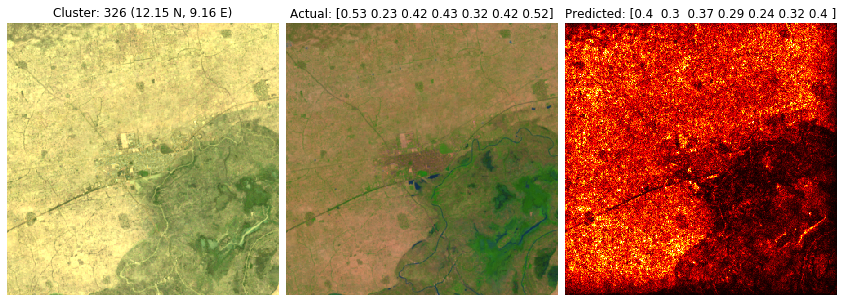

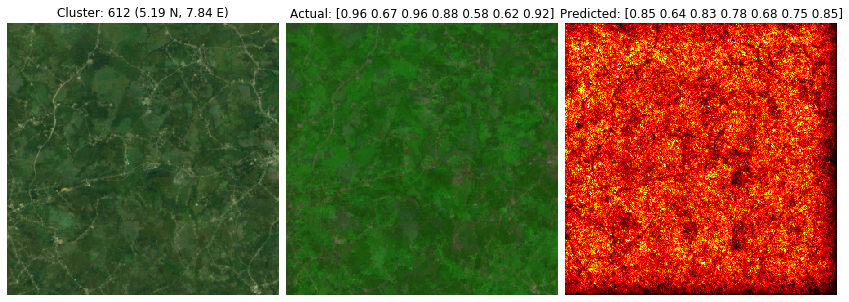

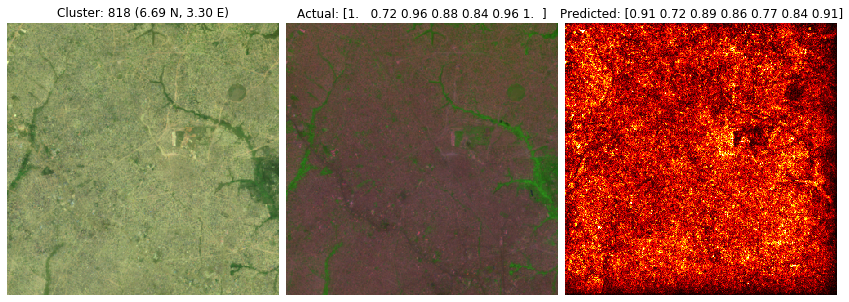

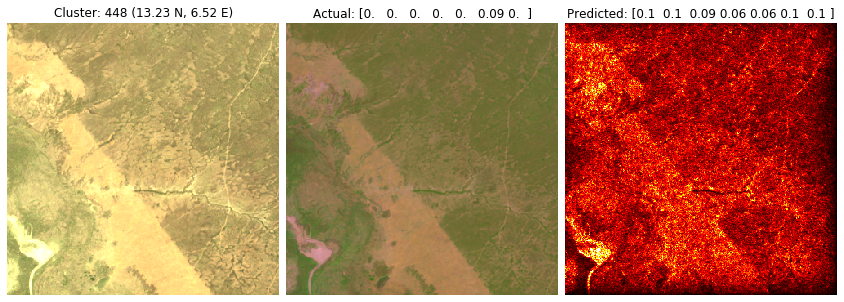

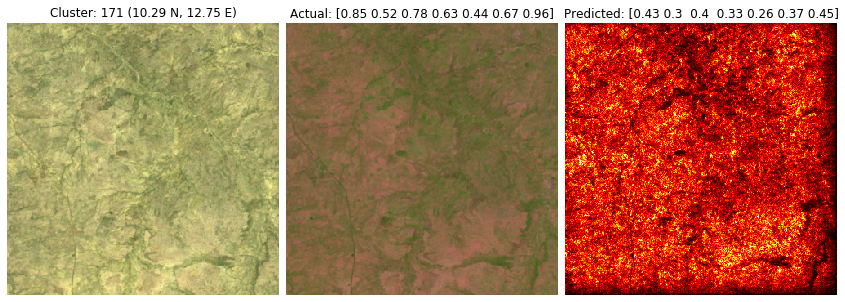

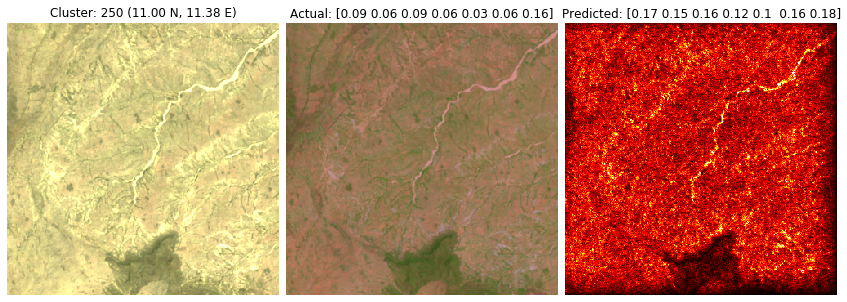

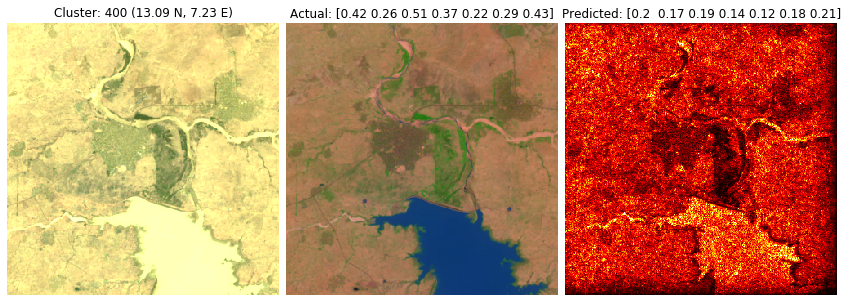

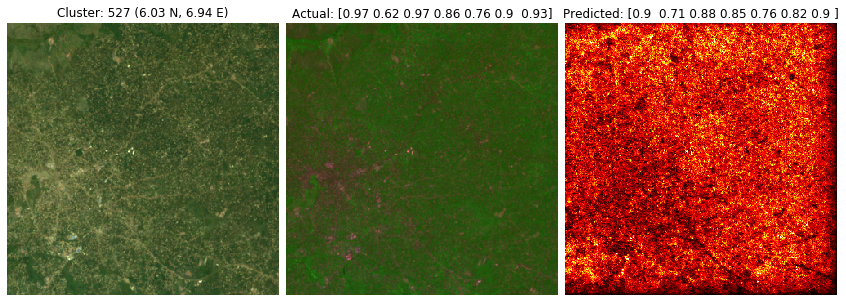

In [10]:
show_saliency_maps(X_raw, saliency, stats, actual, predicted)

* 697: river
* 747: big southern city
* 2: not much
* 84: lake
* 630: estuary
* 332: desert
* 730: artifacts
* 646: coast
* 325: oasis?
* 482: crop fields?
* 38: road

In [11]:
c_ids = np.loadtxt('data/dhs_gps.csv', skiprows=1, delimiter=',')
c_ids = c_ids[:,0].astype(np.int)

In [14]:
mylist = [747, 2, 332, 730, 646, 325, 38, 84]
i = int(np.where(c_ids==697)[0])
X_raw, _, stats = dimages.__getitem__(i) 
X_raw = X_raw[None,:,:,:]
stats = stats[None,:]
for c_id in mylist:
    i = int(np.where(c_ids==c_id)[0])
    a, _, b = dimages.__getitem__(i)
    X_raw = torch.cat((X_raw, a[None,:,:,:]))
    stats = torch.cat((stats, b[None,:]))
print(X_raw.shape)
print(stats.shape)
y = stats[:, vaccs]
saliency, actual, predicted = compute_integrated_gradient(X_raw, y, net, steps=20)
actual = actual.cpu().numpy()
predicted = predicted.detach().cpu().numpy()

torch.Size([9, 9, 333, 333])
torch.Size([9, 25])


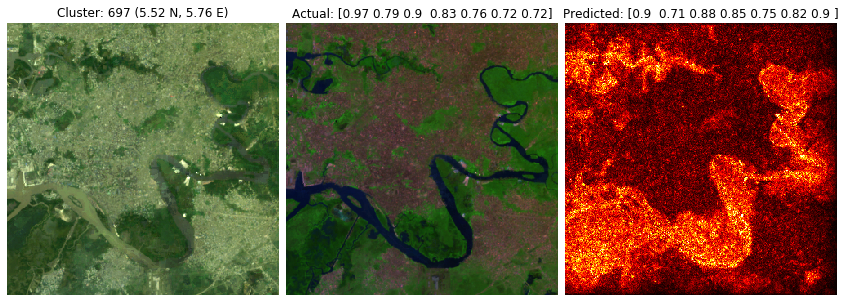

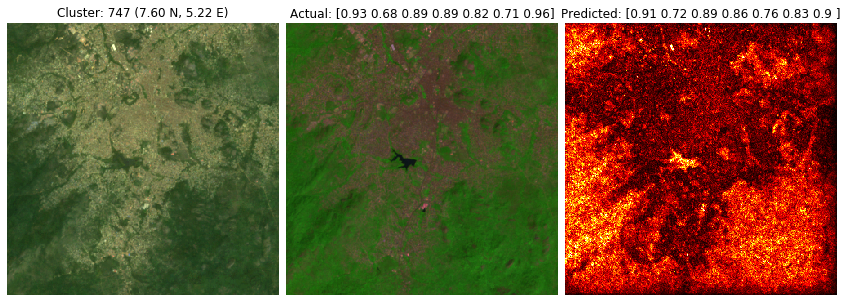

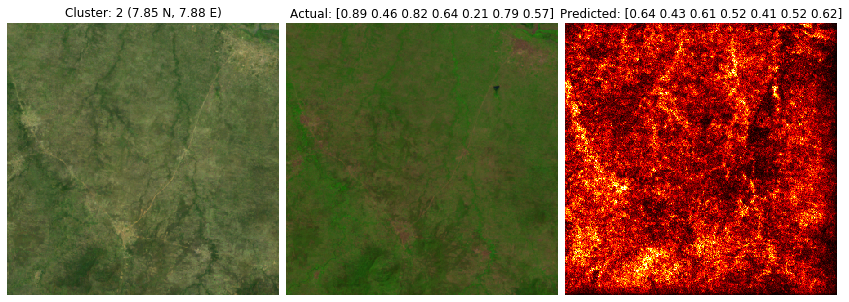

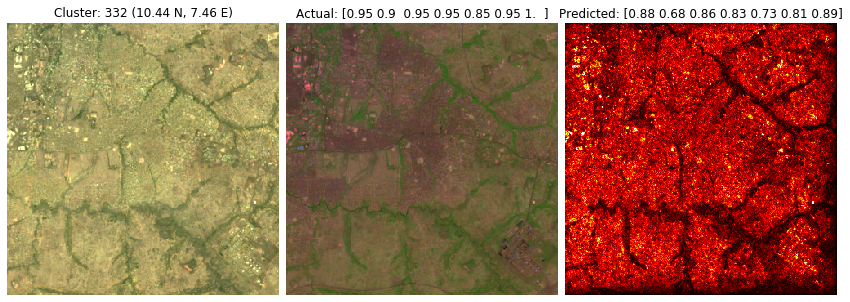

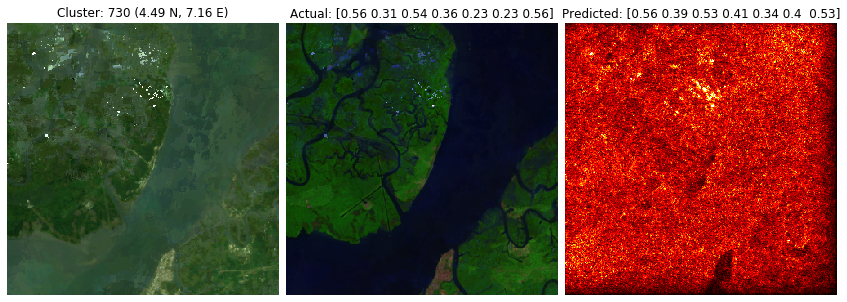

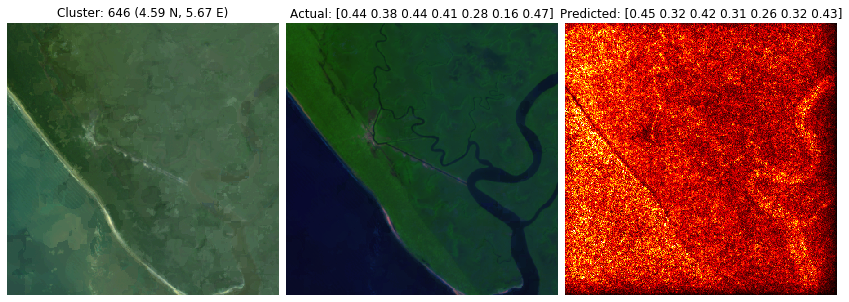

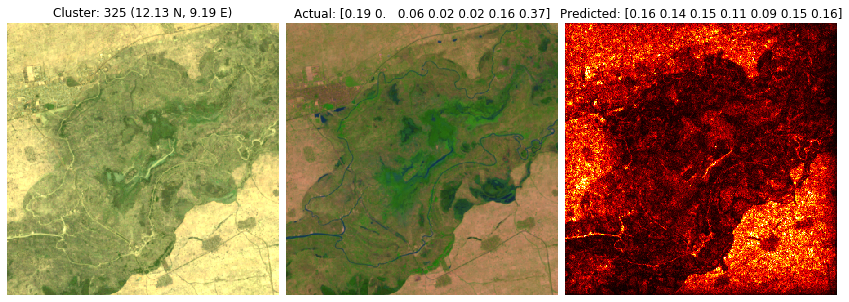

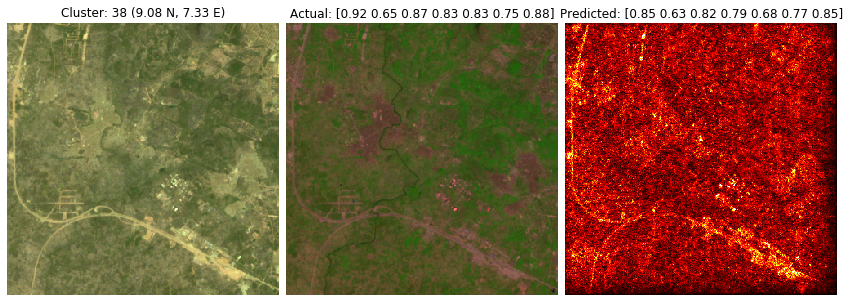

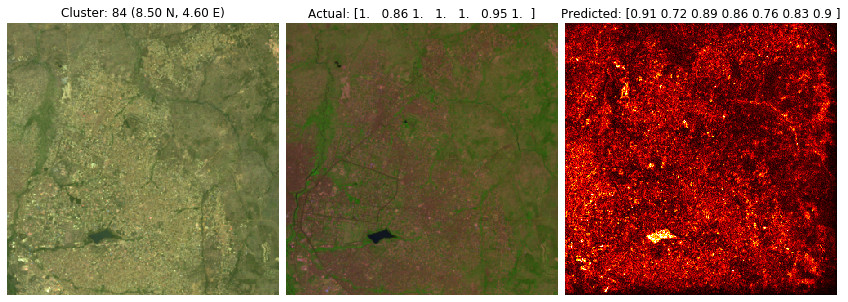

In [15]:
show_saliency_maps(X_raw, saliency, stats, actual, predicted)